In [1]:
import matplotlib.pyplot as plt
from mpi4py import MPI
from petsc4py.PETSc import ScalarType 
import numpy as np
from matplotlib.font_manager import FontProperties

import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem import assemble_scalar, form
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner

## This link is super super helpful!!!
## https://paulpotgieter.org/2023/04/17/installing-fenics-to-run-with-jupyter-notebook/
##########################################################################################
#### https://fenics.readthedocs.io/projects/containers/en/latest/jupyter.html ##########
##########################################################################################
# New opening up options ####
# docker run --rm -ti -v $(pwd):/root/shared -w /root/shared --init -ti -p 8888:8888 dolfinx/lab:stable


In [2]:
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (1.0, 1.0)), n=(16, 16),
                            cell_type=mesh.CellType.triangle)
V = fem.functionspace(msh, ("Lagrange", 1))

facets = mesh.locate_entities_boundary(msh, dim=(msh.topology.dim - 1),
                                       marker=lambda x: np.logical_or.reduce((
                                           np.isclose(x[0], 0.0),
                                           np.isclose(x[0], 1.0),
                                           np.isclose(x[1], 0.0),
                                           np.isclose(x[1], 1.0))))
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

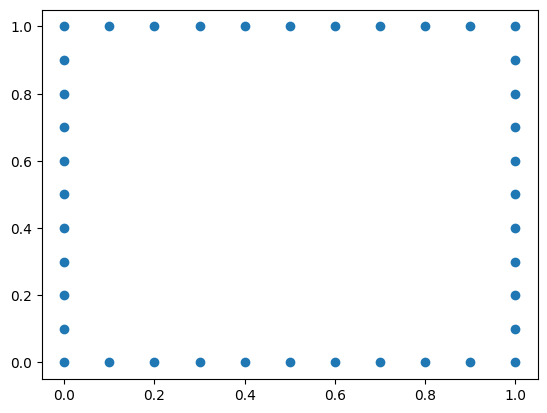

In [3]:
# create boundary points, starting from (0,0), clockwise
n = 11;
x = np.linspace(0, 1, n)
c = np.zeros((4*n-4,2))
c[n:2*n-1,0] = x[1:]
c[2*n-1:3*n-3,0] = 1
c[3*n-3:,0] = np.flip(x[1:])
c[0:n,1] = x
c[n:2*n-2,1] = 1
c[2*n-2:3*n-3,1] = np.flip(x[1:])
c
plt.scatter(c[:,0], c[:,1]) 

In [4]:
###  The source/receiver functions near the boundaries
f_all = []
for i in range(40):
    f = fem.Function(V)
    f.interpolate(lambda x: np.exp(-(pow(x[0] - c[i,0] ,2)+pow(x[1] - c[i,1],2))*20) )
    f_all.append(f)


In [5]:
# atrue = ufl.sin(x[0])**2 + ufl.sin(x[1])**2 + ufl.sin(10*x[0])**2 + ufl.sin(10*x[1])**2  

atrue = fem.Function(V)
atrue.interpolate(lambda x: 1 + ( (x[0] - 0.5)**2 + (x[1] - 0.5)**2  < 0.04 ))


In [12]:
u_trial = ufl.TrialFunction(V)
u_test = ufl.TestFunction(V)

x = ufl.SpatialCoordinate(msh)


M = np.zeros((40,40))
A = np.zeros((40,40))
l = 1
# we used the standard H^1 semi norn inner product
# \mathcal{A}_c(u,v)=\int_{\Omega} \nabla u(x)\cdot \nabla v(x)\mathrm{d}x + ...
# \int_{\Omega} c(x)u(x)v(x)\mathrm{d}x - \lambda \int_{\Omega} u(x)v(x)\mathrm{d}x


for j in range(40):
    for i in range(40):
        # The inner product
        # \langle u,v\rangle_{\mathsf{U}} = \int_{\Omega} \nabla u(x)\cdot\nabla v(x)\mathrm{d}x
        #                                    + \int_{\Omega} c(x)u(x)v(x)\mathrm{d}x
        M[i,j] = assemble_scalar(form(inner( grad(f_all[j]), grad(f_all[i]))*dx)) 

        # The bilinear form
        # \mathcal{A}_c(u,v)=\int_{\Omega} \nabla u(x)\cdot \nabla v(x)\mathrm{d}x + ...
        # \int_{\Omega} c(x)u(x)v(x)\mathrm{d}x - \lambda \int_{\Omega} u(x)v(x)\mathrm{d}x
        A[i,j]  =  M[i,j] + assemble_scalar(form(inner(atrue*f_all[j], f_all[i])*dx ) ) \
                          - assemble_scalar(form(inner(l*f_all[j], f_all[i])*dx))

D = M*np.linalg.inv(A)*M

In [13]:
nk = 21
obj_all_inf = np.zeros(nk,)
obj_all_zero = np.zeros(nk,)
obj_all_small = np.zeros(nk,)
obj_all_large = np.zeros(nk,)

c_all = np.linspace(0, 2, nk)


for k in range(nk):
    # c = (k-(nk-1)/2)*20
    c = c_all[k]
    a = fem.Function(V)
    a.interpolate(lambda x: (1+c) + ( (x[0] - 0.5)**2 + (x[1] - 0.5)**2  < 0.04 ))
    
    A = D*0 # initialize matrix A
    for j in range(40):
        for i in range(40):
            M[i,j] = assemble_scalar(form(inner( grad(f_all[j]), grad(f_all[i]))*dx))
            A[i,j]  =  M[i,j] + assemble_scalar(form(inner(a*f_all[j], f_all[i])*dx ) ) \
                              - assemble_scalar(form(inner(l*f_all[j], f_all[i])*dx))
    A_inv = np.linalg.inv(A)
    
    B = M*A_inv*M
    G = B*A_inv*M
    E = D - B 
    obj_all_inf[k] =  0.5*np.trace(E.transpose()*E)
    obj_all_large[k] =  0.5*np.trace(E.transpose()* np.linalg.inv(np.eye(40) + G/1e8)*E)
    obj_all_small[k] =  0.5*np.trace(E.transpose()* np.linalg.inv(np.eye(40) + G/1e5)*E)
    obj_all_zero[k] =  0.5*np.trace(E.transpose()* np.linalg.inv(np.eye(40) + G/1e-2)*E)

Text(0, 0.5, 'normalized obj. function')

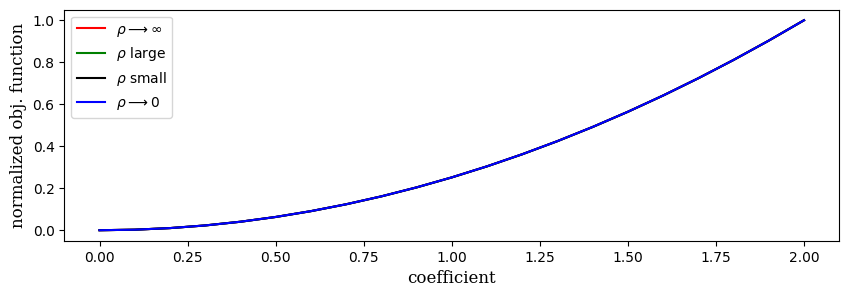

In [14]:
font = FontProperties()
font.set_family('serif')
# font.set_name('Times New Roman')
font.set_size('12')
# font.set_style('italic')

coeffs  = c_all

fig, ax =  plt.subplots(figsize=(10, 3))

ax.plot(coeffs, obj_all_inf/np.max(obj_all_inf),color='r',label =  r'$\rho \longrightarrow \infty$')
ax.plot(coeffs, obj_all_large/np.max(obj_all_large),color='g',label = r'$\rho$ large')
ax.plot(coeffs, obj_all_small/np.max(obj_all_small),color='k',label = r'$\rho$ small')
ax.plot(coeffs, obj_all_zero/np.max(obj_all_zero),color='b',label = r'$\rho \longrightarrow 0$')
ax.legend()
ax.set_xlabel('coefficient', fontproperties=font)
ax.set_ylabel('normalized obj. function', fontproperties=font)
# plt.savefig('Poisson2D-source-basis.pdf',bbox_inches='tight')  

In [ ]:
a = interpolate(Constant(0.5), Va)
a_syn = inner( a * grad(u_trial), grad(u_test)) * dx
L = f * u_test * dx

# solve the forward/state problem to generate synthetic observations
A, b = assemble_system(a_syn, L, bc_state)

u = Function(Vu)
solve(A, u.vector(), b)

ud_pre = Function(Vu)
ud_pre.assign(u)
plot(u)

In [ ]:
# Regularization parameter
gamma = 1e-9

# Define cost function
def cost(u, ud, m, gamma):
    reg = 0.5*gamma * assemble( inner(grad(m), grad(m))*dx ) 
    misfit = 0.5 * assemble( (u-ud)**2*dx)
    return [reg + misfit, misfit, reg]